# Clustering networks

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random as rn
from collections import Counter
from hdbscan import HDBSCAN
from matplotlib.cm import get_cmap
from sklearn.manifold import spectral_embedding
from umap import UMAP

%matplotlib inline

seed = 42
rn.seed(seed)
np.random.seed(seed)
random_state = np.random.RandomState(seed)

Defining the network:

In [2]:
# G_ = nx.read_edgelist("data/air_traffic.edgelist")
# G_ = nx.read_edgelist("data/academic_collaboration.edgelist")
# G_ = nx.dorogovtsev_goltsev_mendes_graph(7)
with open("data/imdb.p", "rb") as f:
    G_ = nx.Graph()
    G_.add_edges_from(pickle.load(f))

print(f"largest connected components: "
      f"{[len(cc) for cc in sorted(nx.connected_components(G_), key=len, reverse=True)[:5]]}")

n_largest_cc = 1
G = G_.subgraph(set.union(*sorted(nx.connected_components(G_), key=len, reverse=True)[:n_largest_cc])).copy()
G_.clear()

largest connected components: [77744, 121, 100, 76, 51]


Reducing dimensions with Spectral Embedding and UMAP and clustering with HDBSCAN:

In [3]:
adj_matrix = nx.to_numpy_array(G)
node_list = list(G.nodes())

embedding = spectral_embedding(adj_matrix, n_components=50, drop_first=False, random_state=random_state)
embedding = UMAP(n_components=2, n_neighbors=30, min_dist=0.0, random_state=random_state).fit_transform(embedding)
clusters = HDBSCAN(min_samples=800, min_cluster_size=800, core_dist_n_jobs=-1).fit_predict(embedding)

print(f"nodes: {len(node_list)}")
counter = Counter(clusters)
print(f"clusters: {len(counter) - 1}")
print(f"cluster sizes: {sorted(counter.items(), key=lambda x: x[1], reverse=True)}")
print(f"noise level: {np.round(counter[-1] / len(clusters), 3)}")

nodes: 77744
clusters: 14
cluster sizes: [(-1, 32983), (13, 14595), (12, 7282), (4, 3775), (0, 3460), (3, 3039), (6, 2465), (5, 1773), (1, 1545), (11, 1394), (9, 1308), (8, 1294), (2, 1005), (7, 929), (10, 897)]
noise level: 0.424


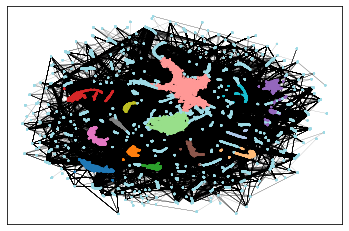

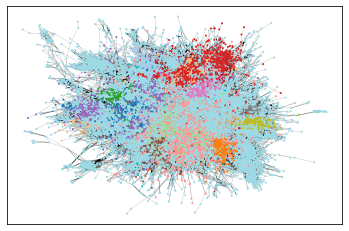

In [4]:
cmap = get_cmap("tab20").colors
cmap = [cmap[i] for i in range(len(cmap)) if i % 2 == 0] + [cmap[i] for i in range(len(cmap)) if i % 2 == 1]
node_colors = [cmap[cluster] for cluster in clusters]

pos_fr = nx.fruchterman_reingold_layout(G, seed=seed)
pos_su = {node_list[i]: embedding[i] for i in range(len(node_list))}

def draw_network(G, pos, node_colors, pdf_name, edge_width=.1, font_size=1):
    # degrees = [x[1] for x in nx.degree(G)]
    # node_sizes = [50 * x / max(degrees) + 1 for x in degrees]
    nx.draw_networkx_nodes(G, pos=pos, node_size=1, node_color=node_colors)
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    # nx.draw_networkx_labels(G, pos=pos, font_size=font_size)
    plt.savefig(f"results/{pdf_name}.pdf")
    plt.show()

draw_network(G, pos=pos_su, node_colors=node_colors, pdf_name="graph_su_1")
draw_network(G, pos=pos_fr, node_colors=node_colors, pdf_name="graph_fr_1")

Removing nodes labeled as noise by HDBSCAN:

In [5]:
G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
node_colors = [cmap[cluster] for cluster in clusters if cluster != -1]

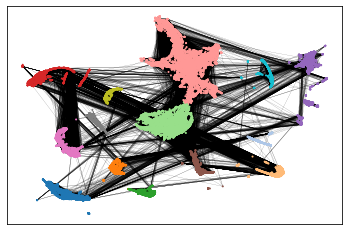

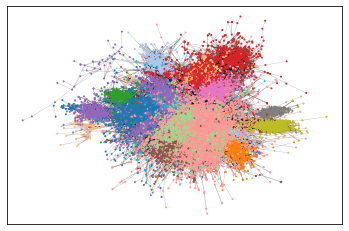

In [6]:
draw_network(G, pos=pos_su, node_colors=node_colors, pdf_name="graph_su_clean_1")
draw_network(G, pos=pos_fr, node_colors=node_colors, pdf_name="graph_fr_clean_1")